<a href="https://colab.research.google.com/github/sushirito/Hg2/blob/main/MD_Small_Molecules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hello there!**
This is a Jupyter notebook for running Molecular Dynamics (MD) simulations using OpenMM engine and GAFF force field for small molecules. Here, we are going to perform the geometry optimization of the molecule using TorchANI (https://github.com/aiqm/torchani) and after, using this geometry as an input to perform molecular dynamics simulations. This notebook is a supplementary material of the paper "***Making it rain: Cloud-based molecular simulations for everyone***" ([link here](https://doi.org/10.1021/acs.jcim.1c00998)) and we encourage you to read it before using this pipeline.



---

**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/pablo-arantes/making-it-rain/issues

**Acknowledgments**
- We would like to thank the OpenMM team for developing an excellent and open source engine.

- We would like to thank the [Roitberg](https://roitberg.chem.ufl.edu/) team for developing the fantastic [TorchANI](https://github.com/aiqm/torchani).

- Making-it-rain by **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes)), **Marcelo D. Polêto** ([@mdpoleto](https://twitter.com/mdpoleto)), **Conrado Pedebos** ([@ConradoPedebos](https://twitter.com/ConradoPedebos)) and **Rodrigo Ligabue-Braun** ([@ligabue_braun](https://twitter.com/ligabue_braun)).


- Also, credit to [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin.

- For related notebooks see: [Making-it-rain](https://github.com/pablo-arantes/making-it-rain)

# **Introduction**

In general, MD simulations rely on 1) a set of atomic coordinates of all atoms on a simulation box and 2) a set of force field parameters that describes the interaction energies between atoms.

In terms of inputs, we wil need:
*  A SMILES notation of your molecule.

Initially, we are going to perform the geometry optimization of the molecule using TorchANI, a PyTorch-based program for training/inference of ANI (ANAKIN-ME) deep learning models to obtain potential energy surfaces and other physical properties of molecular systems. After that, we will use general AMBER force field (GAFF - http://ambermd.org/antechamber/gaff.html) to generate the topology. GAFF is compatible with the AMBER force field and it has parameters for almost all the organic molecules made of C, N, O, H, S, P, F, Cl, Br and I. As a complete force field, GAFF is suitable for study of a great number of molecules in an automatic fashion. We will use LEaP program (https://ambermd.org/tutorials/pengfei/index.php) to build our simulation box. The LEaP program is a portal between many chemical structure file types (.pdb and .mol2, primarily), and the Amber model parameter file types such as .lib, .prepi, parm.dat, and .frcmod. Each of the parameter files contains pieces of information needed for constructing a simulation, whether for energy minimization or molecular dynamics. LEaP functions within a larger workflow described in Section 1.1 of the [Amber Manual](https://ambermd.org/doc12/Amber20.pdf).

The input SMILES example for Ibuprofen: CC(C)CC1=CC=C(C=C1)C(C)C(=O)O

## ---







---
# **Setting the environment for MD calculation**

Firstly, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

1.    Anaconda (https://docs.conda.io/en/latest/miniconda.html)
2.    OpenMM (https://openmm.org/)
3.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
4.    py3Dmol (https://pypi.org/project/py3Dmol/)
5.    Numpy (https://numpy.org/)
6.    Matplotlib (https://matplotlib.org/)
7.    AmberTools (https://ambermd.org/AmberTools.php)
8.    RDKit (https://www.rdkit.org/)
9.    TorchANI (https://github.com/aiqm/torchani)

In [1]:
#@title **Install Conda Colab**
#@markdown It will restart the kernel (session), don't worry.
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:09
🔁 Restarting kernel...


In [1]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
import subprocess
import sys
subprocess.run("rm -rf /usr/local/conda-meta/pinned", shell=True)
subprocess.run("mamba install -c conda-forge ambertools -y", shell=True)
import pytraj as pt
subprocess.run("pip -q install py3Dmol", shell=True)
subprocess.run("pip install git+https://github.com/pablo-arantes/biopandas", shell=True)
subprocess.run("mamba install pytorch torchvision -c pytorch", shell=True)
subprocess.run("pip install torchani", shell=True)
subprocess.run("pip install ase", shell=True)
subprocess.run("mamba install openmm pdbfixer -y", shell=True)
subprocess.run("mamba install openmmforcefields -c conda-forge -y", shell=True)
subprocess.run("pip install prolif==1.1.0", shell=True)
subprocess.run("mamba install -c conda-forge openbabel -y", shell=True)
subprocess.run("mamba install -c conda-forge parmed -y", shell=True)
subprocess.run("pip install --upgrade MDAnalysis==2.4.2", shell=True)



import openbabel as ob
from rdkit import Chem
from rdkit.Chem import AllChem
from openmm import app, unit
from openmm.app import HBonds, NoCutoff, PDBFile
import parmed as pmd
from biopandas.pdb import PandasPdb
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import os
import urllib.request
import numpy as np
import MDAnalysis as mda
import py3Dmol
import openbabel
import pytraj as pt
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from pytraj import matrix
from matplotlib import colors
from IPython.display import set_matplotlib_formats

/usr/local/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:160: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


## Using Google Drive to store topology data

Google Colab does not allow users to keep data on their computing nodes. However, we can use Google Drive to read, write, and store our topology files. Therefore, we suggest to you to:

1.   Create a folder in your own Google Drive and copy the necessary input files there.
2.   Copy the path of your created directory. We will use it below.

In [8]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
#@title **Check if you correctly allocated GPU nodes**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Feb 11 05:06:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

---
# **Loading the necessary input files**

At this point, we should have all libraries and dependencies installed and all necessary input files already at your Google Drive folder.

Below, you should provide your smiles and the pathway of your Google Drive folder where the notebook will create the folder and save your files.

**Please, don't use spaces in smiles and folders names, use _ instead i.e., MyDrive/small_molecule and so on.**

Charge = 0


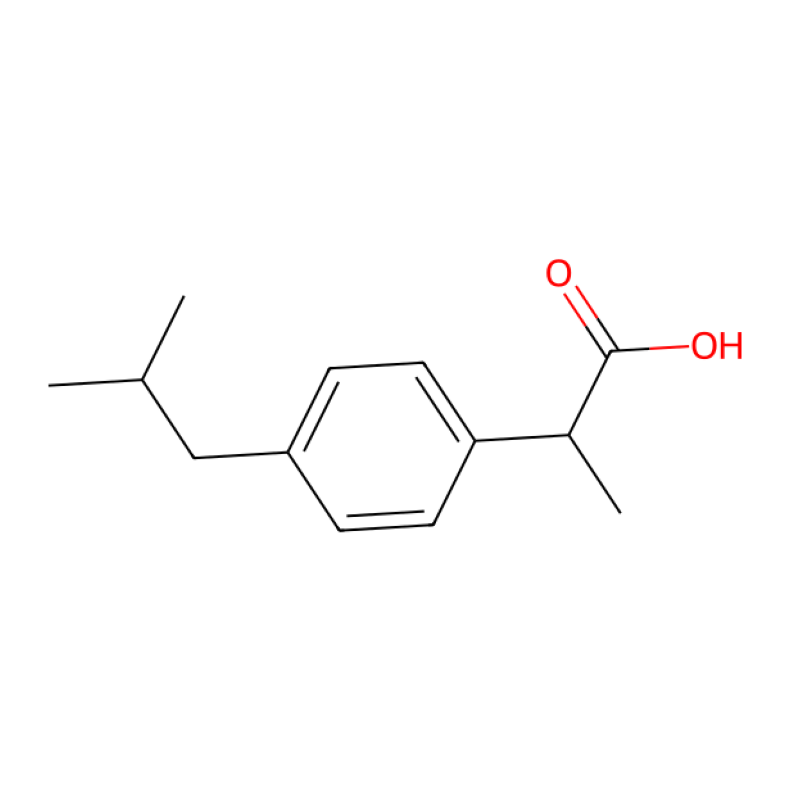

In [10]:
#@title **Please, provide the necessary input files below**:

#@title Upload Image
from google.colab import files
from PIL import Image, ImageOps
from rdkit import Chem
from rdkit.Chem import AllChem,Draw
from rdkit.Chem.Draw import IPythonConsole
import IPython.display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from termcolor import colored
IPythonConsole.ipython_useSVG=True
#@markdown Type the smiles of your molecule. If you don't know your smiles, please, check at https://pubchem.ncbi.nlm.nih.gov/
Smiles = 'CC(C)CC1=CC=C(C=C1)C(C)C(=O)O' #@param {type:"string"}

Google_Drive_Path = '/content/drive/MyDrive/small_molecules' #@param {type:"string"}

workDir = Google_Drive_Path

original_stdout = sys.stdout # Save a reference to the original standard output
with open('mkdir_path.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print("mkdir " + workDir )
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 mkdir_path.sh 2>&1 1>/dev/null
!bash mkdir_path.sh >/dev/null 2>&1
!rm mkdir_path.sh

if os.path.exists(os.path.join(workDir, "smiles.pdb")):
  os.remove(os.path.join(workDir,"smiles.pdb"))
  os.remove(os.path.join(workDir,"smiles.mol"))
  os.remove(os.path.join(workDir,"smiles.png"))
else:
  pass

smiles_fig = Chem.MolFromSmiles(Smiles)
mol = Chem.MolFromSmiles(Smiles)
hmol = Chem.AddHs(mol)
charge_mol = Chem.rdPartialCharges.ComputeGasteigerCharges(hmol)
charge = Chem.GetFormalCharge(hmol)
print("Charge = " + str(charge))

if charge == 0:
  AllChem.EmbedMolecule(hmol)
  hmol.GetConformer(0)
  mp = AllChem.MMFFGetMoleculeProperties(hmol)
  ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
  # Optimize
  AllChem.OptimizeMoleculeConfs(hmol, ff, numThreads=1, maxIters=1000)
  AllChem.MolToMolFile(hmol, (os.path.join(workDir, "smiles.mol")),)
  AllChem.MolToPDBFile(hmol, (os.path.join(workDir, "smiles.pdb")))
  smi_end = Draw.MolToFile(smiles_fig, size=(600, 600), filename=os.path.join(workDir, "smiles.png"))
  original_stdout = sys.stdout # Save a reference to the original standard output
  final_smiles = os.path.join(workDir, "smiles.smi")
  with open(final_smiles, 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(Smiles, ' ')
    sys.stdout = original_stdout
  #print("SMILES:", Smiles)
  img = mpimg.imread(os.path.join(workDir, "smiles.png"))
  plt.figure(figsize = (10,10))
  imgplot = plt.imshow(img)
  plt.axis('off')
  plt.show()
else:
  print(colored("ANI cannot do charged system yet, stay tuned!", 'red'))


In [11]:
#@title **Geometry optimization using TorchANI**:

#@markdown Minimization and energy calculation of the molecule, using TorchANI as the optimizing engine.

#@markdown ANI is a general-purpose neural network-based atomistic potential for organic molecules. Four ANI models have been published, the ANI-1, ANI-1x, ANI-1ccx, and ANI-2x potentials. The ANI-1 model was developed by random sampling conformational space of 57k organic molecules with up to eight heavy atoms, C, N, and O, plus H atoms to have proper chemistry, then running DFT calculations to obtain potential energies for training. ANI-1x was trained to a data set of molecular conformations sampled through an active learning scheme. Active learning is where the model itself is iteratively used to decide what new data should be included in the next iteration. ANI-1ccx was trained to the ANI-1x data set, then retrained to a 10% smaller data set of accurate coupled cluster calculations, resulting in a potential that outperformed DFT in test cases. ANI-2x was trained by adding many millions of data points to the ANI-1x data set, at the same level of theory, but including elements S, F, and Cl. We included the **ANI-1x**, **ANI-1ccx**, and **ANI-2x** models in our notebook.

#@markdown TorchANI will calculate a reliability index, which here is called **RHO**. We set a threshold of 0.6 kcal/mol such that if RHO < 0.6 everything is fine, if RHO > 0.6 be careful and if RHO > 1. The ouput will show a flag in the cases where we have an issue.

#@markdown If you want to know more about **TorchANI**, please, check at https://aiqm.github.io/torchani/

#@markdown Please, select your ANI model:
model_name = "ANI-2x" #@param ["ANI-1x", "ANI-1ccx", "ANI-2x"]

#@markdown Convergence threshold for geometry optimization:

opt_tol = 0.0001 #@param {type:"slider", min:0.0001, max:0.01, step:0.0001}

from typing import List
from ase import Atoms
from ase.lattice.cubic import Diamond
from ase.md.langevin import Langevin
from ase.optimize import BFGS
from ase import io
from ase.io import read, write
from ase import units
from ase.constraints import ExternalForce, FixInternals
import torch
import torchani
import pandas as pd
import numpy as np
from torchani.units import HARTREE_TO_KCALMOL

device = torch.device('cpu')

if model_name == "ANI-2x":
  model = torchani.models.ANI2x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI2x().ase()
  print("Model = ANI2x")
elif model_name == "ANI-1ccx":
  model = torchani.models.ANI1ccx(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI1ccx().ase()
  print("Model = ANI1ccx")
elif model_name == "ANI-1x":
  model = torchani.models.ANI1x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI1x().ase()
  print("Model = ANI1x")
else:
  pass

def mol2arr(mols, device=device):
    coordinates = []
    spices = []
    for mol in mols:
        pos = mol.GetConformer().GetPositions().tolist()
        atomnums = [a.GetAtomicNum() for a in mol.GetAtoms()]
        coordinates.append(pos)
        spices.append(atomnums)
    coordinates = torch.tensor(coordinates,
                               requires_grad=True,
                               device=device)
    species = torch.tensor(spices, device=device)
    return coordinates, species

mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, "smiles.mol")), removeHs=False)
mol = io.read(os.path.join(workDir, "smiles.mol"))
coordinates, species = mol2arr([mol_deg], device)
tensor1 = coordinates.detach().numpy()
atoms = Atoms(mol, positions=tensor1[0])
atoms.center(vacuum=3.0)
atoms.set_calculator(calculator)
print("Begin minimization")
opt = BFGS(atoms)
opt.run(fmax=opt_tol)
write((os.path.join(workDir, "smiles.xyz")), format="xyz", images=atoms)

atomic_symbols = []
xyz_coordinates = []

with open((os.path.join(workDir, "smiles.xyz")), "r") as file:
  for line_number,line in enumerate(file):
      if line_number == 0:
          num_atoms = int(line)
      elif line_number == 1:
          comment = line # might have useful information
      else:
          atomic_symbol, x, y, z = line.split()
          atomic_symbols.append(atomic_symbol)
          xyz_coordinates.append([float(x),float(y),float(z)])

from rdkit.Geometry import Point3D
conf = mol_deg.GetConformer()

for i in range(mol_deg.GetNumAtoms()):
  x,y,z = xyz_coordinates[i]
  conf.SetAtomPosition(i,Point3D(x,y,z))
AllChem.MolToMolFile(mol_deg, (os.path.join(workDir, "smiles_min.mol")))
AllChem.MolToPDBFile(mol_deg, (os.path.join(workDir, "smiles_min.pdb")))

#TorchANI Energies
mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, "smiles_min.mol")), removeHs=False)
coordinates, species = mol2arr([mol_deg], device)
energy = model((species, coordinates)).energies
energies_list = []
for i in range(0,8,1):
  modeli = model[i]
  energyi = modeli((species, coordinates)).energies
  energies_list.append(energyi.item())
qbc_factors = np.std(energies_list)
num_atoms = (species >= 0).sum(dim=1)
qbc_factors = (qbc_factors / num_atoms.sqrt()) * HARTREE_TO_KCALMOL
# print(qbc_factors.item())
  # derivative = torch.autograd.grad(energy.sum(), coordinates)[0]
  # force = -derivative
# print(energy.item())

# print("Energy RHO factor")
print("Energy= " + str(energy.item()))
print("RHO factor= " + str(qbc_factors.item()))


/usr/local/lib/python3.11/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")


/usr/local/lib/python3.11/site-packages/torchani/resources/
/usr/local/lib/python3.11/site-packages/torchani/resources/
Model = ANI2x
Begin minimization
      Step     Time          Energy          fmax
BFGS:    0 05:07:17   -17865.249554        1.155786
BFGS:    1 05:07:17   -17865.263126        1.673765


<ipython-input-11-9299aa7aa83b>:70: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(calculator)


BFGS:    2 05:07:17   -17865.281961        0.335359
BFGS:    3 05:07:17   -17865.288907        0.293336
BFGS:    4 05:07:18   -17865.297371        0.191617
BFGS:    5 05:07:18   -17865.302953        0.117578
BFGS:    6 05:07:18   -17865.305431        0.091479
BFGS:    7 05:07:18   -17865.307882        0.076329
BFGS:    8 05:07:18   -17865.309136        0.078623
BFGS:    9 05:07:18   -17865.310042        0.074096
BFGS:   10 05:07:18   -17865.310804        0.067162
BFGS:   11 05:07:18   -17865.311534        0.053559
BFGS:   12 05:07:18   -17865.312209        0.054753
BFGS:   13 05:07:18   -17865.312882        0.049702
BFGS:   14 05:07:18   -17865.313673        0.056062
BFGS:   15 05:07:18   -17865.314560        0.059511
BFGS:   16 05:07:18   -17865.315392        0.067142
BFGS:   17 05:07:19   -17865.316046        0.045695
BFGS:   18 05:07:19   -17865.316606        0.048241
BFGS:   19 05:07:19   -17865.317174        0.051042
BFGS:   20 05:07:19   -17865.317741        0.060307
BFGS:   21 0

In [12]:
#@title **Check your geometry**
import warnings
warnings.filterwarnings('ignore')
import py3Dmol

view = py3Dmol.view(width=800, height=600)
view.addModel(open(os.path.join(workDir, "smiles_min.mol"),'r').read(),'mol')
view.addStyle({'stick':{'colorscheme':'greenCarbon','radius':0.3}})
view.setViewStyle({'style':'outline','color':'black','width':0.1})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [13]:
from rdkit import Chem
from rdkit.Chem import PandasTools
import openbabel

# from openff.toolkit.typing.engines.smirnoff import ForceField
# import parmed

#@title **Parameters to generate the molecule topology on GAFF2 force field:**


Force_field = "ff19SB"
ff = "leaprc.protein.ff19SB"
# if Force_field == "ff19SB":
#   ff = "leaprc.protein.ff19SB"
# else:
#   ff = "leaprc.protein.ff14SB"

Water_type = "TIP3P" #@param ["TIP3P", "OPC"]
if Water_type == "TIP3P":
  water = "leaprc.water.tip3p"
  water_box = "TIP3PBOX"
else:
  water = "leaprc.water.opc"
  water_box = "OPCBOX"
# elif Water_type == "OPC":
  # water = "leaprc.water.tip3p"
  # water_box ="set SYS box {50,50,50}"

#@markdown Size Box (Angstrons):

Size_box = 12 #@param {type:"slider", min:10, max:20, step:1}
size_box = Size_box

#@markdown **ATTENTION**: Give the concentration in Molar units, AMBER tleap will neutralize your system automatically:

Ions = "NaCl" #@param ["NaCl", "KCl" ]

Concentration = "0.15" #@param {type:"string"}


Ligand_Force_field = "GAFF2"

# Ligand_net_charges = "0" #@param {type:"string", min:-10, max:10, step:1}

#@markdown ---
tleap = os.path.join(workDir, "tleap.in")
top_nw = os.path.join(workDir, "SYS_nw.prmtop")
crd_nw = os.path.join(workDir, "SYS_nw.crd")
pdb_nw = os.path.join(workDir, "SYS_nw.pdb")
top = os.path.join(workDir, "SYS_gaff2.prmtop")
crd = os.path.join(workDir, "SYS_gaff2.crd")
pdb = os.path.join(workDir, "SYS.pdb")
ligand_pdb = os.path.join(workDir, "smiles_min.pdb")
ligand_noh = os.path.join(workDir, "ligand_noh.pdb")
ligand_h = os.path.join(workDir, "ligand_h.pdb")
ligand_mol2 = os.path.join(workDir, "ligand.mol2")
ligand_frcmod = os.path.join(workDir, "ligand.frcmod")
lig_new = os.path.join(workDir, "ligand_gaff.pdb")
protein_ligand = os.path.join(workDir, "protein_ligand.pdb")
lib = os.path.join(workDir, "lig.lib")

gaff_command1 = "pdb4amber -i " + str(ligand_pdb) + " -o " + str(ligand_h)
gaff_command3 = "antechamber -i " + str(ligand_h) + " -fi pdb -o " + str(ligand_mol2) + " -fo mol2 -c bcc -nc " + str(charge) + " -rn LIG -at gaff2"
gaff_command4 = "parmchk2 -i " + str(ligand_mol2) + " -f mol2 -o " + str(ligand_frcmod) + " -s gaff2"

original_stdout = sys.stdout # Save a reference to the original standard output

with open('gaff.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(gaff_command1)
    print(gaff_command3)
    print(gaff_command4)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 gaff.sh 2>&1 1>/dev/null
!bash gaff.sh >/dev/null 2>&1

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.gaff2
LIG = loadmol2 """ + str(ligand_mol2) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""saveoff LIG """ + str(lib) + "\n"
"""savepdb LIG """ + str(lig_new) + "\n"
"""quit""")
f.close()

tleap_command = "tleap -f " + str(tleap)
# cat_command = "cat " + str(starting_end) + " " + str(lig_new) + str(" > ") + str(protein_ligand)

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_tleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(tleap_command)
    # print(cat_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null

# ppdb = PandasPdb().read_pdb(protein_ligand)
# ppdb.df['ATOM'] = ppdb.df['ATOM']
# ppdb.df['OTHERS'] = [ppdb.df['OTHERS'] != 'OTHERS']
# ppdb.to_pdb(path=protein_ligand, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.DNA.OL15
source leaprc.RNA.OL3
source leaprc.GLYCAM_06j-1
source leaprc.gaff2
source """  + str(water) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""loadoff """ + str(lib) + "\n"
"""SYS = loadmol2 """ + str(ligand_mol2) + "\n"
"""alignaxes SYS
savepdb SYS """ + str(pdb_nw) + "\n"
"""saveamberparm SYS """ + str(top_nw) + " " + str(crd_nw) + "\n"
"""solvatebox SYS """ + str(water_box) + " " + str(size_box) +  """ 0.7
saveamberparm SYS """ + str(top) + " " + str(crd) + "\n"
"""savepdb SYS """ + str(pdb) + "\n"
"""quit""")
f.close()

tleap_command = "tleap -f " + str(tleap)

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_tleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(tleap_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

SYS = os.path.join(workDir, "SYS*")
rm_sys = "rm " + SYS

original_stdout = sys.stdout # Save a reference to the original standard output

with open('rm_sys.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(rm_sys)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 rm_sys.sh 2>&1 1>/dev/null
!bash rm_sys.sh 2> /dev/null

!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null


!grep "Volume:" leap.log > temp.txt
with open("temp.txt", 'r') as f:
  for line in f:
        vol = float(line.split()[1])

vol_lit  = vol * pow(10, -27)
atom_lit = 9.03 * pow(10, 22)
conc = float(Concentration)
num_ion = int(vol_lit * (conc/0.15) * atom_lit)

if Ions == "NaCl":
  pos_neut = "Na+ 0"
  pos_num = "Na+ " + str(num_ion)
  Cl_num = num_ion
else:
  pos_neut = "K+ 0"
  pos_num = "K+ " + str(num_ion)
  Cl_num = num_ion

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.DNA.OL15
source leaprc.RNA.OL3
source leaprc.GLYCAM_06j-1
source leaprc.gaff2
source """  + str(water) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""loadoff """ + str(lib) + "\n"
"""SYS = loadmol2 """ + str(ligand_mol2) + "\n"
"""alignaxes SYS
check SYS
charge SYS
addions SYS """ + str(pos_neut) + "\n"
"""addions SYS Cl- 0
check SYS
charge SYS
savepdb SYS """ + str(pdb_nw) + "\n"
"""saveamberparm SYS """ + str(top_nw) + " " + str(crd_nw) + "\n"
"""solvatebox SYS """ + str(water_box) + " " + str(size_box) +  """ 0.7 """ + "\n"
"""addIonsRand SYS """ + str(pos_num) + """ Cl- """ + str(Cl_num) + "\n"
"""saveamberparm SYS """ + str(top) + " " + str(crd) + "\n"
"""savepdb SYS """ + str(pdb) + "\n"
"""quit""")
f.close()

!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null

pdb_amber = os.path.exists(pdb)
top_amber = os.path.exists(top)
crd_amber = os.path.exists(crd)

if pdb_amber == True and top_amber == True and crd_amber == True:
  print("Successfully generated topology! :-)")
else:
  print("ERROR: Check your inputs! ")
!!rm *.sh  ANTECHAMBER* ATOMTYPE* temp.txt >/dev/null 2>&1

Successfully generated topology! :-)


[]

## Let's take a look on our simulation box:

In [ ]:
#@title **Show 3D structure**
import warnings
warnings.filterwarnings('ignore')
import py3Dmol

show_box = True #@param {type:"boolean"}
box_opacity = 0.6 #@param {type:"slider", min:0, max:1, step:0.1}

def show_pdb(show_box = False):
  view = py3Dmol.view(width=800, height=600)
  view.addModel(open(pdb,'r').read(),'pdb')
  HP = ['LIG']
  view.addStyle({'and':[{'resn':HP}]},
                {'stick':{'colorscheme':'greenCarbon','radius':0.3}})
  view.setViewStyle({'style':'outline','color':'black','width':0.1})

  if show_box:
    view.addSurface(py3Dmol.SAS, {'opacity': box_opacity, 'color':'white'})

  view.zoomTo()
  return view


show_pdb(show_box).show()

---
# **Equilibrating the simulation box**

Proper MD equilibration protocol is designed to equilibrate both temperature and pressure throughout the simulation box while preserving the molecule conformation. In addition, we also allow the solvent to accomodate around the protein, creating proper solvation layers.

Below, we will set up the MD equilibration parameters, such as temperature, pressure and the desired simulation time. We will define the force constant used to restraint protein heavy-atoms in place and the frequency at which we want to save atomic coordinates in a trajectory file (.dcd).

After you are done, you can run the next 2 cells to equilibrate your system.

In [ ]:
#@title ### **Parameters for MD Equilibration protocol:**

# remove whitespaces
Jobname = 'eq' #@param {type:"string"}

Ligand_Force_field = "GAFF2"
top = os.path.join(workDir, "SYS_gaff2.prmtop")
crd = os.path.join(workDir, "SYS_gaff2.crd")
pdb = os.path.join(workDir, "SYS.pdb")


Minimization_steps = "20000" #@param ["1000", "5000", "10000", "20000", "50000", "100000"]

#@markdown Simulation time (in nanoseconds) and integration time (in femtoseconds):
Time = "5" #@param {type:"string"}
stride_time_eq = Time
Integration_timestep = "2" #@param ["0.5", "1", "2", "3", "4"]
dt_eq = Integration_timestep

#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = 298 #@param {type:"string"}
temperature_eq = Temperature
Pressure = 1 #@param {type:"string"}
pressure_eq = Pressure

#@markdown Position restraints force constant (in kJ/mol):
Force_constant = 800 #@param {type:"slider", min:0, max:2000, step:100}

#@markdown Frequency to write the trajectory file (in picoseconds):

Write_the_trajectory = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_eq = Write_the_trajectory
#@markdown Frequency to write the log file (in picoseconds):

Write_the_log = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_log_eq = Write_the_log


#@markdown ---


In [ ]:
#@title **Runs an Equilibration MD simulation (NPT ensemble)**
#@markdown Now, let's equilibrate our system!

###########################################
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import pytraj as pt

from sys import stdout, exit, stderr
import os, math, fnmatch

#############################################
# Defining MD simulation parameters

jobname = os.path.join(workDir, Jobname)
coordinatefile = crd
pdbfile = pdb
topologyfile = top

time_ps = float(Time)*1000
simulation_time = float(time_ps)*picosecond		# in ps
dt = int(dt_eq)*femtosecond
temperature = float(temperature_eq)*kelvin
savcrd_freq = int(write_the_trajectory_eq)*picosecond
print_freq  = int(write_the_log_eq)*picosecond

pressure	= float(pressure_eq)*bar

restraint_fc = int(Force_constant) # kJ/mol

nsteps  = int(simulation_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))

#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file

def restraints(system, crd, fc, restraint_array):

	boxlx = system.getDefaultPeriodicBoxVectors()[0][0].value_in_unit(nanometers)
	boxly = system.getDefaultPeriodicBoxVectors()[1][1].value_in_unit(nanometers)
	boxlz = system.getDefaultPeriodicBoxVectors()[2][2].value_in_unit(nanometers)

	if fc > 0:
		# positional restraints for all heavy-atoms
		posresPROT = CustomExternalForce('k*periodicdistance(x, y, z, x0, y0, z0)^2;')
		posresPROT.addPerParticleParameter('k')
		posresPROT.addPerParticleParameter('x0')
		posresPROT.addPerParticleParameter('y0')
		posresPROT.addPerParticleParameter('z0')

		for atom1 in restraint_array:
			atom1 = int(atom1)

			xpos  = crd.positions[atom1].value_in_unit(nanometers)[0]
			ypos  = crd.positions[atom1].value_in_unit(nanometers)[1]
			zpos  = crd.positions[atom1].value_in_unit(nanometers)[2]

			posresPROT.addParticle(atom1, [fc, xpos, ypos, zpos])

		system.addForce(posresPROT)

	return system
##############################################

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tPDB file = " + str(pdbfile))
print("\tTopology file = " + str(topologyfile))

print("\n\tSimulation_time = " + str(simulation_time))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps))

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################

print("\n> Setting the system:\n")


print("\t- Reading topology and structure file...")
prmtop = AmberPrmtopFile(topologyfile)
inpcrd = AmberInpcrdFile(coordinatefile)

print("\t- Creating system and setting parameters...")
nonbondedMethod = PME
nonbondedCutoff = 1.0*nanometers
ewaldErrorTolerance = 0.0005
constraints = HBonds
rigidWater = True
constraintTolerance = 0.000001
friction = 1.0
system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)


print("\t- Applying restraints. Force Constant = " + str(Force_constant) + "kJ/mol")
pt_system = pt.iterload(coordinatefile, topologyfile)
pt_topology = pt_system.top
restraint_array = pt.select_atoms('!(:H*) & !(:WAT) & !(:Na+) & !(:Cl-) & !(:Mg+) & !(:K+)', pt_topology)

system = restraints(system, inpcrd, restraint_fc, restraint_array)

print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator...")
integrator = LangevinIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
    simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

print("\t- Energy minimization: " + str(Minimization_steps) + " steps")
simulation.minimizeEnergy(tolerance=10*kilojoule/mole/nanometer, maxIterations=int(Minimization_steps))

print("\t-> Potential Energy = " + str(simulation.context.getState(getEnergy=True).getPotentialEnergy()))

print("\t- Setting initial velocities...")
simulation.context.setVelocitiesToTemperature(temperature)

#############################################
# Running Equilibration on NPT ensemble

dcd_file = jobname + ".dcd"
log_file = jobname + ".log"
rst_file = jobname + ".rst"
prv_rst_file = jobname + ".rst"
pdb_file = jobname + ".pdb"

# Creating a trajectory file and reporters
dcd = DCDReporter(dcd_file, nsavcrd)
firstdcdstep = (nsteps) + nsavcrd
dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # charmm doesn't like first step to be 0

simulation.reporters.append(dcd)
simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=nsteps, remainingTime=True, separator='\t\t'))
simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

print("\n> Simulating " + str(nsteps) + " steps...")
simulation.step(nsteps)

simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


##################################
# Writing last frame information of stride
print("\n> Writing state file (" + str(rst_file) + ")...")
state = simulation.context.getState( getPositions=True, getVelocities=True )
with open(rst_file, 'w') as f:
	f.write(XmlSerializer.serialize(state))

last_frame = int(nsteps/nsavcrd)
print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
positions = simulation.context.getState(getPositions=True).getPositions()
PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Finished!\n")

---
# **Running a Production MD simulation**

Finally, we will proceed with the Production simulation itself using the equilibrated system coordinates as input structure.

Note that we will use here a *.rst state file* , which contains atomic velocities and positions from the last frame of the equilibration simulation, guaranteeing that our production simulation begins from a thermodynamically equilibrated system.

Another important information here is the **Number_of_strides** and the **Stride_Time**. In this notebook, we simulate a defined number of *strides*, so the **simulation time = Number_of_strides*Stride_Time**. For example, we can simulate 100ns by setting *Number_of_strides=10* and *Stride_Time=10 ns*.

**Important: at the end of the Production simulation, we concatenate all strides to create a complete trajectory file which can be visualized and analyzed**

The idea behind this approach is to make use of the intermitent 12h/24h period that Google Colab allows us to use its GPUs.

In [ ]:
#@markdown ### **Provide input file names below:**

Equilibrated_PDB = 'eq.pdb' #@param {type:"string"}
State_file = 'eq.rst' #@param {type:"string"}

#@markdown ---
#@markdown ### **Parameters for MD Production protocol:**


# remove whitespaces
Jobname = 'prod' #@param {type:"string"}

Ligand_Force_field = "GAFF2"

top = os.path.join(workDir, "SYS_gaff2.prmtop")
crd = os.path.join(workDir, "SYS_gaff2.crd")
pdb = os.path.join(workDir, "SYS.pdb")


#@markdown Simulation time (in nanoseconds), number of strides (integers) and integration timestep (in femtoseconds):
Stride_Time = "10" #@param {type:"string"}
stride_time_prod = Stride_Time
Number_of_strides = "1" #@param {type:"string"}
nstride = Number_of_strides
Integration_timestep = "2" #@param ["0.5", "1", "2", "3", "4"]
dt_prod = Integration_timestep

#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = 298 #@param {type:"string"}
temperature_prod = Temperature
Pressure = 1 #@param {type:"string"}
pressure_prod = Pressure

#@markdown Frequency to write the trajectory file (in picoseconds):
Write_the_trajectory = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_prod = Write_the_trajectory

#@markdown Frequency to write the log file (in picoseconds):
Write_the_log = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_log_prod = Write_the_log

#@markdown ---

In [ ]:
#@title **Runs a Production MD simulation (NPT ensemble) after equilibration**
#
###########################################
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *

from sys import stdout, exit, stderr
import os, math, fnmatch

#############################################
# Defining MD simulation parameters

jobname = os.path.join(workDir, str(Jobname))
coordinatefile = crd
pdbfile = os.path.join(workDir, Equilibrated_PDB)
topologyfile = top
equil_rst_file = os.path.join(workDir, State_file)


stride_time_ps = float(stride_time_prod)*1000
stride_time = float(stride_time_ps)*picosecond
nstride = int(Number_of_strides)
dt = int(dt_prod)*femtosecond
temperature = float(temperature_prod)*kelvin
savcrd_freq = int(write_the_trajectory_prod)*picosecond
print_freq  = int(write_the_log_prod)*picosecond

pressure	= float(pressure_prod)*bar

simulation_time = stride_time*nstride
nsteps  = int(stride_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
firststride = 1 # must be integer
#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file
##############################################

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tPDB file = " + str(pdbfile))
print("\tTopology file = " + str(topologyfile))

print("\n\tSimulation_time = " + str(stride_time*nstride))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps*nstride))
print("\tNumber of strides = " + str(nstride) + " (" + str(stride_time) + " in each stride)")

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tSave checkpoint each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################

print("\n> Setting the system:\n")

print("\t- Reading topology and structure file...")
prmtop = AmberPrmtopFile(topologyfile)
inpcrd = AmberInpcrdFile(coordinatefile)

print("\t- Creating system and setting parameters...")
nonbondedMethod = PME
nonbondedCutoff = 1.0*nanometers
ewaldErrorTolerance = 0.0005
constraints = HBonds
rigidWater = True
constraintTolerance = 0.000001
friction = 1.0
system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)

print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator...")
integrator = LangevinIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
	simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

#############################################
# Opening a loop of extension NSTRIDE to simulate the entire STRIDE_TIME*NSTRIDE
for n in range(1, nstride + 1):

	print("\n\n>>> Simulating Stride #" + str(n) + " <<<")

	dcd_file = jobname + "_" + str(n) + ".dcd"
	log_file = jobname + "_" + str(n) + ".log"
	rst_file = jobname + "_" + str(n) + ".rst"
	prv_rst_file = jobname + "_" + str(n-1) + ".rst"
	pdb_file = jobname + "_" + str(n) + ".pdb"

	if os.path.exists(rst_file):
		print("> Stride #" + str(n) + " finished (" + rst_file + " present). Moving to next stride... <")
		continue

	if n == 1:
		print("\n> Loading previous state from equilibration > " + equil_rst_file + " <")
		with open(equil_rst_file, 'r') as f:
			simulation.context.setState(XmlSerializer.deserialize(f.read()))
			currstep = int((n-1)*nsteps)
			currtime = currstep*dt.in_units_of(picosecond)
			simulation.currentStep = currstep
			simulation.context.setTime(currtime)
			print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")

	else:
		print("> Loading previous state from > " + prv_rst_file + " <")
		with open(prv_rst_file, 'r') as f:
			simulation.context.setState(XmlSerializer.deserialize(f.read()))
			currstep = int((n-1)*nsteps)
			currtime = currstep*dt.in_units_of(picosecond)
			simulation.currentStep = currstep
			simulation.context.setTime(currtime)
			print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")


	dcd = DCDReporter(dcd_file, nsavcrd)
	firstdcdstep = (currstep) + nsavcrd
	dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # first step should not be 0

	simulation.reporters.append(dcd)
	simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=(nsteps*nstride), remainingTime=True, separator='\t\t'))
	simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

	print("\n> Simulating " + str(nsteps) + " steps... (Stride #" + str(n) + ")")
	simulation.step(nsteps)

	simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


	##################################
	# Writing last frame information of stride
	print("\n> Writing state file (" + str(rst_file) + ")...")
	state = simulation.context.getState( getPositions=True, getVelocities=True )
	with open(rst_file, 'w') as f:
		f.write(XmlSerializer.serialize(state))

	last_frame = int(nsteps/nsavcrd)
	print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
	positions = simulation.context.getState(getPositions=True).getPositions()
	PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Finished!\n")

In [ ]:
#@title **Concatenate and align the trajectory**
#@markdown **Important**: The **Google Drive Path**, **Jobname**, **Number of strides**, **stride time** and **trajectory saved frequency** should be the same you have been used to run your simulation in the previous steps.

import MDAnalysis as mda
from MDAnalysis.analysis import align, rms

Google_Drive_Path = '/content/Drive/small_molecule' #@param {type:"string"}
workDir = Google_Drive_Path
Equilibrated_PDB = 'eq.pdb' #@param {type:"string"}
Jobname = "prod" #@param {type: "string"}
Skip = "1" #@param ["1", "2", "5", "10", "20", "50"]
stride_traj = Skip
Output_format = "dcd" #@param ["dcd", "pdb", "trr", "xtc"]
first_stride = "1" #@param {type:"string"}
Number_of_strides = "1" #@param {type:"string"}
nstride = int(Number_of_strides)
stride_time = "10" #@param {type:"string"}
trajectory_saved_frequency = "10" #@param ["10", "100", "200", "500", "1000"]
traj_save_freq = trajectory_saved_frequency
# Remove_waters = "no" #@param ["yes", "no"]
# stride_id_as_ref_for_alignment = "1" #@param {type: "string"}
output_prefix = first_stride+"-"+str(int(first_stride)+nstride-1)

stride_time_ps = float(stride_time)*1000
simulation_time_analysis = stride_time_ps*nstride
simulation_ns = float(stride_time)*int(Number_of_strides)
number_frames = int(simulation_time_analysis)/int(traj_save_freq)
number_frames_analysis = number_frames/int(stride_traj)


# nw_dcd = os.path.join(workDir, str(Jobname) + output_prefix + "_nw." + str(Output_format))
# nw_pdb = os.path.join(workDir, str(Jobname) +  "_nw.pdb")
whole_pdb = os.path.join(workDir, str(Jobname) +  "_whole.pdb")
whole_dcd = os.path.join(workDir, str(Jobname) + output_prefix + "_whole." + str(Output_format))
template =  os.path.join(workDir, str(Jobname) + '_%s.dcd')
pdb = os.path.join(workDir, Equilibrated_PDB)

flist = [template % str(i) for i in range(int(first_stride), int(first_stride) + nstride)]
ref = [template % int(1)]

u1 = mda.Universe(os.path.join(workDir, "SYS_gaff2.prmtop"), flist)
u2 = mda.Universe(os.path.join(workDir, "SYS_gaff2.prmtop"), ref)

u2.trajectory[0] # set u2 to first frame

# print(rms.rmsd(u1.select_atoms('name CA').positions, u2.select_atoms('name CA').positions, superposition=False))

align.AlignTraj(u1, u2, select='resname LIG', in_memory=True).run()

with mda.Writer(whole_dcd, u1.select_atoms("all").n_atoms) as W:
  for ts in u1.trajectory[::int(Skip)]:
      W.write(u1.select_atoms("all"))
whole = u2.select_atoms("all")
whole.write(whole_pdb)
traj_dcd_check = os.path.exists(whole_dcd)
traj = whole_dcd
pdb_ref = whole_pdb

# nw = u1.select_atoms("not (resname WAT)")
# if Remove_waters == "yes":
#   with mda.Writer(nw_dcd, nw.n_atoms) as W:
#     for ts in u1.trajectory[::int(Skip)]:
#         W.write(nw)
#   not_waters = u2.select_atoms("not (resname WAT)")
#   not_waters.write(nw_pdb)
#   traj_dcd_check = os.path.exists(nw_dcd)
#   traj = nw_dcd
#   pdb_ref = nw_pdb
# else:
#   pass

traj_load = pt.load(traj, os.path.join(workDir, "SYS_gaff2.prmtop"))
print(traj_load)

pt_topology = traj_load.top
restraint_array = pt.select_atoms('!(:WAT) & !(:Na+) & !(:Cl-) & !(:Mg+) & !(:K+)', pt_topology)
first_atom = restraint_array[0]
last_atom = restraint_array[-1]
mask_end = "@" + str(first_atom+1) + "-" + str(last_atom+1)

if traj_dcd_check == True:
  print("Trajectory concatenated successfully! :-)")
else:
  print("ERROR: Check your inputs! ")

In [ ]:
#@title **Load, view and check the trajectory**
#@markdown This will take a few minutes. Another coffee would be great. :-)

import warnings
warnings.filterwarnings('ignore')

#py3dmol functions
class Atom(dict):
  def __init__(self, line):
    self["type"] = line[0:6].strip()
    self["idx"] = line[6:11].strip()
    self["name"] = line[12:16].strip()
    self["resname"] = line[17:20].strip()
    self["resid"] = int(int(line[22:26]))
    self["x"] = float(line[30:38])
    self["y"] = float(line[38:46])
    self["z"] = float(line[46:54])
    self["sym"] = line[76:78].strip()

  def __str__(self):
    line = list(" " * 80)
    line[0:6] = self["type"].ljust(6)
    line[6:11] = self["idx"].ljust(5)
    line[12:16] = self["name"].ljust(4)
    line[17:20] = self["resname"].ljust(3)
    line[22:26] = str(self["resid"]).ljust(4)
    line[30:38] = str(self["x"]).rjust(8)
    line[38:46] = str(self["y"]).rjust(8)
    line[46:54] = str(self["z"]).rjust(8)
    line[76:78] = self["sym"].rjust(2)
    return "".join(line) + "\n"

class Molecule(list):
  def __init__(self, file):
    for line in file:
      if "ATOM" in line or "HETATM" in line:
        self.append(Atom(line))

    def __str__(self):
      outstr = ""
      for at in self:
        outstr += str(at)
      return outstr

if number_frames_analysis > 10:
  stride_animation = number_frames_analysis/10
else:
  stride_animation = 1

u = mda.Universe(pdb_ref, traj)

# Write out frames for animation
protein = u.select_atoms('not (resname WAT)')
i = 0
for ts in u.trajectory[0:len(u.trajectory):int(stride_animation)]:
    if i > -1:
        with mda.Writer('' + str(i) + '.pdb', protein.n_atoms) as W:
            W.write(protein)
    i = i + 1
# Load frames as molecules
molecules = []
for i in range(int(len(u.trajectory)/int(stride_animation))):
    with open('' + str(i) + '.pdb') as ifile:
        molecules.append(Molecule(ifile))

models = ""
for i in range(len(molecules)):
  models += "MODEL " + str(i) + "\n"
  for j,mol in enumerate(molecules[i]):
    models += str(mol)
  models += "ENDMDL\n"
#view.addModelsAsFrames(models)

# Animation
view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(models)
for i, at in enumerate(molecules[0]):
    default = {"cartoon": {'color': 'spectrum'}}
    view.setViewStyle({'style':'outline','color':'black','width':0.1})
    view.setStyle({'model': -1, 'serial': i+1}, at.get("pymol", default))
    HP = ['LIG']
    view.setStyle({"model":-1,'and':[{'resn':HP}]},{'stick':{'radius':0.3}})
view.zoomTo()
view.animate({'loop': "forward"})
view.show()

---
---
# **Analysis**

Although visualizing your trajectory can be quite useful, sometimes you also want more quantitative data.

Analyses of MD trajectories vary a lot and we do not intend to cover it all here. However, one can make use of MDanalysis or PyTraj to easily analyze simulations.

Below, you can find a few examples of code snippets that can help you to shed some light on your simulation behavior.

In [ ]:
#@title **Please, run the present cell to check your atom numbers, you will need it for further analysis**:

#@title **Please, run the present cell to check your atom numbers, you will need it for further analysis**:
remove_hydrogens = "Yes" #@param ["Yes", "No"]

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolTransforms
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from IPython.display import SVG
import ipywidgets as widgets
import rdkit
from rdkit.Chem.Draw import IPythonConsole
AllChem.SetPreferCoordGen(True)
from IPython.display import Image

def show_atom_number(mol, label):
    for atom in mol.GetAtoms():
        atom.SetProp(label, str(atom.GetIdx()+1))
    return mol

a_file = open(os.path.join(workDir, "smiles.smi"))
file_contents = a_file.read()
smiles_fig = Chem.MolFromSmiles(file_contents)
if remove_hydrogens == "No":
  hmol = Chem.AddHs(smiles_fig)
  mol2 = show_atom_number(hmol, 'atomNote')
  Draw.MolToFile(mol2, size=(600, 600), filename=os.path.join(workDir, 'atom_numbers.png'))
  img = mpimg.imread(os.path.join(workDir, 'atom_numbers.png'))
  plt.figure(figsize = (10,10))
  imgplot = plt.imshow(img)
  plt.axis('off')
  plt.show()
else:
  mol2 = show_atom_number(smiles_fig, 'atomNote')
  Draw.MolToFile(mol2, size=(600, 600), filename=os.path.join(workDir, 'atom_numbers.png'))
  img = mpimg.imread(os.path.join(workDir, 'atom_numbers.png'))
  plt.figure(figsize = (10,10))
  imgplot = plt.imshow(img)
  plt.axis('off')
  plt.show()

In [ ]:
#@title **Compute distance between the atoms**
#@markdown **Provide output file names below:**
Output_name = 'distance_atoms' #@param {type:"string"}
#@markdown **Type the number of atoms separated by commas and without spaces (1,2,3...):**
Selection_1 = '1' #@param {type:"string"}
Selection_2 = '2' #@param {type:"string"}

mask = "@" + str(Selection_1) + " @" + str(Selection_2)
dist = pt.distance(traj_load, mask)
print("Selected atoms = " + Selection_1 + ", "  + Selection_2 + "\n")
dist_mean = mean(dist)
dist_stdev = stdev(dist)
print("Distance Average = " + str("{:.2f}".format(dist_mean)) + " \u00B1 " + str("{:.2f}".format(dist_stdev)) + " Å")

time = len(dist)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)

df = pd.Series(dist)
running_aver = df.rolling(window =10).mean()

# Plotting:
ax = plt.plot(time_array, dist, alpha=0.2, color = 'magenta', linewidth = 1.0)
ax = plt.plot(time_array, running_aver, alpha=1, color = 'magenta', linewidth = 1.0)

plt.xlim(0, simulation_ns)
#plt.ylim(2, 6)

plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("Distance [$\AA$]", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(dist)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

In [ ]:
#@title **Plot distance as a distribution**

#@markdown **Provide output file names below:**
Output_name = 'distance_dist' #@param {type:"string"}

ax = sb.kdeplot(dist, color="magenta", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('Distance [$\AA$]', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

In [ ]:
#@title **Compute specific dihedral angles**
#@markdown **Provide output file names below:**
Output_name = 'dihedral_angle' #@param {type:"string"}
#@markdown **Type the number of atoms:**
Atom_1 = '1' #@param {type:"string"}
Atom_2 = '2' #@param {type:"string"}
Atom_3 = '4' #@param {type:"string"}
Atom_4 = '5' #@param {type:"string"}

mask = "@" + str(Atom_1) + " @" + str(Atom_2) + " @" + str(Atom_3) + " @" + str(Atom_4)
dih = pt.dihedral(traj_load, mask)
print("Selected atoms = " + Atom_1 + ", " + Atom_2 + ", " + Atom_3 + ", " + Atom_4 + "\n")
dih_mean = mean(dih)
dih_stdev = stdev(dih)
print("Dihedral Angle Average = " + str("{:.2f}".format(dih_mean)) + " \u00B1 " + str("{:.2f}".format(dih_stdev)) + "°")

time = len(dih)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)

df = pd.Series(dih)
running_aver = df.rolling(window =10).mean()

# Plotting:
ax = plt.plot(time_array, dih, alpha=0.2, color = 'orange', linewidth = 1.0)
ax = plt.plot(time_array, running_aver, alpha=1, color = 'orange', linewidth = 1.0)

plt.xlim(0, simulation_ns)
#plt.ylim(2, 6)

plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("Dihedral Angle ($^\circ$)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(dih)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

In [ ]:
#@title **Plot dihedral angle as a distribution**

#@markdown **Provide output file names below:**
Output_name = 'dihedral_dist' #@param {type:"string"}

ax = sb.kdeplot(dih, color="orange", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('Dihedral Angle ($^\circ$)', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

In [ ]:
#@title **Compute intramolecular hydrogen bonds**
#@markdown **Provide output file names below:**
Output_name = 'hbond_intra' #@param {type:"string"}
mask_hbond = 'acceptormask ' + mask_end + ' donormask ' + mask_end
hb = pt.hbond(traj_load, options=mask_hbond, dtype='dict', distance =3.5)

hb_end = hb['total_solute_hbonds']
time = len(hb_end)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)
hb.keys()
# print(hb_end)
# hb_end_mean = mean(hb_end)
# hb_end_stdev = stdev(hb_end)
# print("Hydrogen Bonds Average = " + str("{:.2f}".format(hb_end_mean)) + " \u00B1 " + str("{:.2f}".format(hb_end_stdev)))

df = pd.Series(hb_end)
running_aver = df.rolling(window =10).mean()

# Plotting:
ax = plt.plot(time_array, hb_end, alpha=0.2, color = 'black', linewidth = 1.0)
ax = plt.plot(time_array, running_aver, alpha=1, color = 'black', linewidth = 1.0)

plt.xlim(0, simulation_ns)

plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("Hydrogen Bonds", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(hb_end)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

In [ ]:
#@title **Compute hydrogen bonds between your molecule and waters**
#@markdown **Provide output file names below:**
Output_name = 'hbond_solv' #@param {type:"string"}
mask_hbond1 = 'acceptormask ' + mask_end + ' donormask :WAT'
mask_hbond2 = 'acceptormask :WAT' + ' donormask ' + mask_end

hb1 = pt.hbond(traj_load, options=mask_hbond1, dtype='dict', distance =3.5)
hb2 = pt.hbond(traj_load, options=mask_hbond2, dtype='dict', distance =3.5)

hb_end1 = hb1['total_solute_hbonds']
hb_end2 = hb2['total_solute_hbonds']
hb_total = hb_end1 + hb_end2
time = len(hb_total)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)
# hb.keys()
# print(hb_total)
# hb_end_mean = mean(hb_total)
# hb_end_stdev = stdev(hb_total)
# print("Hydrogen Bonds Average = " + str("{:.2f}".format(hb_end_mean)) + " \u00B1 " + str("{:.2f}".format(hb_end_stdev)))

# running_averages_hb = moving_average(hb_total,4)
df = pd.Series(hb_total)
running_aver = df.rolling(window =10).mean()
# Plotting:
ax = plt.plot(time_array, df, alpha=0.2, color = 'black', linewidth = 1.0)
ax = plt.plot(time_array, running_aver, alpha=1, color = 'black', linewidth = 1.0)

plt.xlim(0, simulation_ns)

plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("Hydrogen Bonds", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(hb_total)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

In [ ]:
#@title **Compute solvent-accessible surface area (SASA) of your molecule**
#@markdown **Provide output file names below:**
Output_name = 'sasa' #@param {type:"string"}


sasa = pt.molsurf(traj_load, mask_end)

time = len(sasa)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)

df = pd.Series(sasa)
running_aver = df.rolling(window =10).mean()

# Plotting:
ax = plt.plot(time_array, sasa, alpha=0.2, color = 'darkcyan', linewidth = 1.0)
ax = plt.plot(time_array, running_aver, alpha=1, color = 'darkcyan', linewidth = 1.0)

plt.xlim(0, simulation_ns)
#plt.ylim(2, 6)

plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("SASA ($\AA^{2}$)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(sasa)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

In [ ]:
#@title **Plot solvent-accessible surface area (SASA) as a distribution**

#@markdown **Provide output file names below:**
Output_name = 'sasa_dist' #@param {type:"string"}

ax = sb.kdeplot(sasa, color="darkcyan", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('SASA ($\AA^{2}$)', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

In [ ]:
#@title **Compute RMSD of your molecule**
#@markdown **Provide output file names below:**
Output_name = 'rmsd' #@param {type:"string"}


rmsd = pt.rmsd(traj_load, ref = 0, mask = mask_end)

time = len(rmsd)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)

df = pd.Series(rmsd)
running_aver = df.rolling(window =10).mean()

# Plotting:
ax = plt.plot(time_array, rmsd, alpha=0.2, color = 'blue', linewidth = 1.0)
ax = plt.plot(time_array, running_aver, alpha=1, color = 'blue', linewidth = 1.0)

plt.xlim(0, simulation_ns)
#plt.ylim(2, 6)

plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("RMSD [$\AA$]", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(rmsd)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

In [ ]:
#@title **Plot RMSD as a distribution**

#@markdown **Provide output file names below:**
Output_name = 'rmsd_dist' #@param {type:"string"}

ax = sb.kdeplot(rmsd, color="blue", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('RMSD [$\AA$]', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

In [ ]:
#@title **Compute radius of gyration of your molecule**

#@markdown **Provide output file names below:**
Output_name = 'radius_gyration' #@param {type:"string"}

radgyr = pt.radgyr(traj_load, mask = mask_end)
time = len(rmsd)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)

df = pd.Series(radgyr)
running_aver = df.rolling(window =10).mean()

# Plotting:
plt.plot(time_array, radgyr, alpha=0.2, color = 'green', linewidth = 1.0)
plt.plot(time_array, running_aver, alpha=1, color = 'green', linewidth = 1.0)

plt.xlim(0, simulation_ns)
#plt.ylim(2, 6)

plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("Radius of gyration ($\AA$)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(radgyr)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

In [ ]:
#@title **Plot radius of gyration as a distribution**

#@markdown **Provide output file names below:**
Output_name = 'radius_gyration_dist' #@param {type:"string"}

ax = sb.kdeplot(radgyr, color="green", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('Radius of gyration ($\AA$)', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

In [ ]:
#@title **Compute RMSF**

#@markdown **Provide output file names below:**
Output_name = 'rmsf' #@param {type:"string"}


rmsf = pt.rmsf(traj_load, mask_end)
bfactor = pt.bfactors(traj_load, byres=False)

# Plotting:
plt.plot(rmsf[:,1], alpha=1.0, color = 'red', linewidth = 1.0)

plt.xlabel("Atom", fontsize = 14, fontweight = 'bold')
plt.ylabel("RMSF ($\AA$)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.xlim(0, len(rmsf[:-1]))

#plt.xticks(np.arange(min(rmsf[:1]), max(rmsf[:1])))
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(rmsf)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

In [ ]:
#@title **Calculate eigenvectors of Principle Component Analysis (PCA)**
data = pt.pca(traj_load, fit=True, ref=0, mask=mask_end, n_vecs=2)
#print('projection values of each frame to first mode = {} \n'.format(data[0][0]))
#print('projection values of each frame to second mode = {} \n'.format(data[0][1]))
#print('eigvenvalues of first two modes', data[1][0])
#print("")
#print('eigvenvectors of first two modes: \n', data[1][1])

last_frame = len(time_array)

stride_ticks_f = (last_frame)/5
ticks_frame = np.arange(0,(len(time_array) + float(stride_ticks_f)), float(stride_ticks_f))
a = ticks_frame.astype(float)
a2 = a.tolist()
stride_ticks_t = (simulation_ns)/5
tick_time = np.arange(0,(float(simulation_ns) + float(stride_ticks_t)), float(stride_ticks_t))
b = tick_time.astype(float)

#@markdown **Provide output file names below:**
Output_name = 'PCA' #@param {type:"string"}

Output_PC1 = 'PC1' #@param {type:"string"}
Output_PC2 = 'PC2' #@param {type:"string"}

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # high resolution
projection_data = data[0]
plt.title(r'PCA')
PC1 = data[0][0]
PC2 = data[0][1]

a = plt.scatter(PC1,PC2, c=range(int(number_frames_analysis)), cmap='Greens', marker='o',s=8, alpha=1)
plt.clim(0, last_frame)

plt.xlabel('PC1', fontsize = 14, fontweight = 'bold')
plt.ylabel('PC2', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
# N = len(number_frames)
# x2 = np.arange(N)

cbar1 = plt.colorbar(a, orientation="vertical")
cbar1.set_label('Time(ns)', fontsize = 14, fontweight = 'bold')
cbar1.set_ticks(a2)
cbar1.set_ticklabels(b.round(decimals=3))

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

pc1=pd.DataFrame(PC1)
pc1.to_csv(os.path.join(workDir, Output_PC1 + ".csv"))
pc2=pd.DataFrame(PC2)
pc2.to_csv(os.path.join(workDir, Output_PC2 + ".csv"))

In [ ]:
#@title **Plot Principal Component 1 (PC1) and Principal Component 2 (PC2) as a distribution**
Output_name = 'PCA_dist' #@param {type:"string"}


fig = plt.figure(figsize=(9,5))

plt.subplot(1, 2, 1)
ax = sb.kdeplot(PC1, color="green", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('PC1', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
plt.subplot(1, 2, 2)
ax2 = sb.kdeplot(PC2, color="purple", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('PC2', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(False)


plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')